# Dataset

## Imports 

In [2]:
# Task: Import the necessary libraries

from pathlib import Path

import torch
import numpy as np
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import matplotlib.pyplot as plt

## DataSet Creation 

In [37]:
# Task: Create a torch Dataset which implements the following functionality:

# 1) Create a list of all 2D slices. To so we need to extract all slices from all subjects
# 2) Extract the corresponding label path for each slice path
# 3) Load slice and label
# 4) Data Augmentation. Make sure that slice and mask are augmented identically. Hint: Remember imgaug
# 5) Return slice and mask

class LungDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    
    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob('*'):
            slice_path = subject / 'data'
            for slice in slice_path.glob('*'):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index('data')] = 'masks'
        return Path(*parts)
    
    
    def augment(self, slice, mask):
        random_seed = torch.randint(0, 100000, (1, ))[0].item()
        imgaug.seed(random_seed)
        
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        
        return slice_aug, mask_aug
    
    
    def __len__(self):
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        
        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
            
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

## Validation

In [38]:
# Task: Test the dataset by showing the same (tumorous) slice 9 times. Make sure that the label
# mask is augmented correctly

seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [39]:
path = Path('Data/Atrium/Task06_Lung/Preprocessed/train/')
dataset = LungDataset(path, seq)

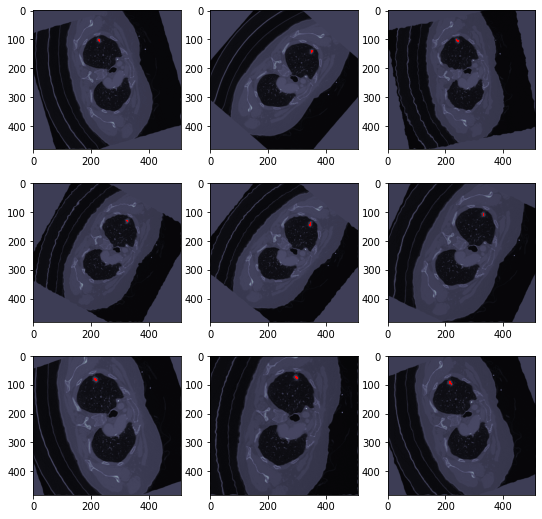

In [52]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[122]
        mask_ = np.ma.masked_where(mask == 0, mask)
        
        axis[i][j].imshow(slice[0], cmap='bone')
        axis[i][j].imshow(mask_[0], cmap='autumn')